In [1]:
# import required libraries
import pandas as pd
import numpy as np
import requests
import json
import math

from pandas.io.json import json_normalize

# import map rendering library
import folium
# import a tool for concerting an address into latitude and longitude 
from geopy.geocoders import Nominatim
import geopy.geocoders

# import matplotlib and associated plotting modukes
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import library for validating SSL encryted URLs
import ssl
import certifi
from urllib import request

<h1>Part 1 - Comparing healthcare accessbility between the U.S and Canada</h1>
In this part, I categorize healthcare accessbility as two factors - Wait time and cost. For wait time, I will approximate this factor by looking at the <b>number of households</b> to <b>number of healthcare facility</b> ratio and <b>covered area</b> to <b>number of healthcare facility</b> ratio. As for the coste, I will look at the healthcare expenditure between Ontario and Massachusetts.

<h3>Data collection and cleaning</h3>
The first part of this project is to read in all the data I have collected online. These data are in excel, csv or json format.

In [2]:
# read excel file that contains area info for toronto wards
toronto_area = pd.read_excel('data/Toronto_Wards_Area.xlsx')

In [3]:
# rename columns
toronto_area_clean = toronto_area.rename(columns={'City of Toronto Profiles':'Ward_ID', 'Unnamed: 1':'Area'})
# drop the first 11 rows and reset index
toronto_area_clean.drop(list(np.arange(0,11)), inplace = True)
toronto_area_clean.reset_index(drop = True, inplace = True)

toronto_area_clean.dtypes

Ward_ID    object
Area       object
dtype: object

In [4]:
# change the column type
toronto_area_clean.astype({'Ward_ID':'int64', 'Area':'float64'}).dtypes
# get radius of each toronto ward in meters to the nearest 100
get_radius = lambda x: np.sqrt(x/np.pi)
toronto_area_clean['Radius'] = toronto_area_clean['Area'].apply(get_radius) * 1000
toronto_area_clean['Radius'] = toronto_area_clean['Radius'] // 100 * 100

print("The shape of 'toronto_area_clean': ", toronto_area_clean.shape)
toronto_area_clean.head()

The shape of 'toronto_area_clean':  (25, 3)


,Ward_ID,Area,Radius
0,1,48.38,3900.0
1,2,37.36,3400.0
2,3,40.03,3500.0
3,4,15.33,2200.0
4,5,24.98,2800.0


In [5]:
# read csv file that contains the location data of toronto wards
toronto_loc = pd.read_csv('data/Toronto_Wards_Location.csv')

In [6]:
toronto_loc.columns

Index(['_id', 'AREA_ID', 'DATE_EFFECTIVE', 'DATE_EXPIRY', 'AREA_ATTR_ID',
       'AREA_TYPE_ID', 'PARENT_AREA_ID', 'AREA_TYPE', 'AREA_CLASS_ID',
       'AREA_CLASS', 'AREA_SHORT_CODE', 'AREA_LONG_CODE', 'AREA_NAME',
       'AREA_DESC', 'FEATURE_CODE', 'FEATURE_CODE_DESC', 'TRANS_ID_CREATE',
       'TRANS_ID_EXPIRE', 'X', 'Y', 'LONGITUDE', 'LATITUDE', 'OBJECTID',
       'Shape__Area', 'Shape__Length', 'geometry'],
      dtype='object')

In [7]:
# select the columns that will be used in the final dataframe and rename the columns
loc_columns = ['AREA_SHORT_CODE', 'AREA_NAME', 'LONGITUDE','LATITUDE']
toronto_loc_clean = toronto_loc[loc_columns]
# rename dataframe columns
toronto_loc_clean = toronto_loc_clean.rename(columns = {'AREA_SHORT_CODE':'Ward_ID','AREA_NAME':'Ward','LONGITUDE':'Long','LATITUDE':'Lat'})

toronto_loc_clean.dtypes

Ward_ID      int64
Ward        object
Long       float64
Lat        float64
dtype: object

In [8]:
print("The shape of 'toronto_loc_clean': ",toronto_loc_clean.shape)
toronto_loc_clean.head()

The shape of 'toronto_loc_clean':  (25, 4)


,Ward_ID,Ward,Long,Lat
0,7,Humber River-Black Creek,-79.530272,43.750724
1,6,York Centre,-79.467810,43.752565
2,18,Willowdale,-79.416500,43.776886
3,11,University-Rosedale,-79.394317,43.671139
4,19,Beaches-East York,-79.306673,43.689268


In [9]:
# read excel file that contains demo information of toronto wards
toronto_demo = pd.read_excel('data/Toronto_Wards_Demographics_2016.xlsx')

In [10]:
# after viewing the dataframe, drop the first 15 rows
toronto_demo_clean = toronto_demo.drop(list(np.arange(15)))
# set dataframe index
toronto_demo_clean.set_index('City of Toronto Profiles', inplace = True)
toronto_demo_clean.head()

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,...,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26
City of Toronto Profiles,,,,,,,,,,,,,,,,,,,,,
Population,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,Toronto,Ward 1,Ward 2,Ward 3,Ward 4,Ward 5,Ward 6,Ward 7,Ward 8,Ward 9,...,Ward 16,Ward 17,Ward 18,Ward 19,Ward 20,Ward 21,Ward 22,Ward 23,Ward 24,Ward 25
Total - Age,2731570,118040,118020,129080,108805,116685,104320,108035,114395,108470,...,94580,110080,118800,109465,110280,112605,105540,98800,102390,102275
0 to 4 years,136000,6815,5230,6370,5770,6530,5510,6575,6300,5020,...,5015,4715,5065,6895,6160,5905,4880,4950,5860,4890
5 to 9 years,135025,7500,5905,5630,5540,6695,5195,6895,7025,4460,...,5185,5140,4420,6550,6330,6250,4875,5125,6385,5565


In [11]:
# set dataframe column names as a list of integer from 0 to 25
demo_col_int = list(np.arange(26))
toronto_demo_clean.columns = demo_col_int
# drop the index name
toronto_demo_clean.index.name = None
# transpose the dataframe
toronto_demo_clean = toronto_demo_clean.T

# select the columns that will be used in the final analysis
demo_columns = ['Total - Private households by number of household maintainers - 25% sample data', '  Median total income of households in 2015 ($)']
toronto_demo_clean = toronto_demo_clean[demo_columns]
toronto_demo_clean.reset_index(inplace = True)
# rename the columns
toronto_demo_clean.columns = ['Ward_ID', 'Number of Households', 'Income of Households']
# remove the row that contains the sum
toronto_demo_clean.drop([0], inplace = True)
toronto_demo_clean.reset_index(drop = True, inplace = True)
# check column type
toronto_demo_clean.dtypes

Ward_ID                  int64
Number of Households    object
Income of Households    object
dtype: object

In [12]:
toronto_demo_clean.astype('float64').dtypes
print("The shape of 'toronto_demo_clean': ",toronto_demo_clean.shape)
toronto_demo_clean.head()

The shape of 'toronto_demo_clean':  (25, 3)


,Ward_ID,Number of Households,Income of Households
0,1,37895,61169
1,2,45045,82870
2,3,59735,71859
3,4,50315,65546
4,5,44930,53469


<H3>Produce the final dataframe that contains all the essential information regarding Toronto wards<\H3>

In [13]:
from functools import reduce
# merge the 3 dataframes that contain different information regarding toronto wards into a single dataframe
toronto_dfs = [toronto_area_clean, toronto_loc_clean, toronto_demo_clean]
toronto_df = reduce(lambda left, right: pd.merge(left, right, on = 'Ward_ID', how = 'outer'), toronto_dfs)

toronto_df.set_index('Ward', inplace = True)
toronto_df.drop(columns = ['Ward_ID'], inplace = True)
toronto_df.head()

,Area,Radius,Long,Lat,Number of Households,Income of Households
Ward,,,,,,
Etobicoke North,48.38,3900.0,-79.584667,43.719405,37895,61169
Etobicoke Centre,37.36,3400.0,-79.552534,43.664431,45045,82870
Etobicoke-Lakeshore,40.03,3500.0,-79.520874,43.621646,59735,71859
Parkdale-High Park,15.33,2200.0,-79.467340,43.650121,50315,65546
York South-Weston,24.98,2800.0,-79.493371,43.694951,44930,53469


Repeat the same process for the Boston neighborhood data

In [14]:
# read csv file that contains area infomation of boston neighborhoods
boston_area = pd.read_csv('data/Boston_Neighborhoods_Area.csv')
# rename dataframe columns
area_columns = ['Name', 'Neighborhood_ID', 'SqMiles']
boston_area_clean = boston_area[area_columns]
boston_area_clean.head()
# convert the area column from square miles to square kilometer
SqMiles_to_SqKm = 2.59
area_convert = lambda x: x * SqMiles_to_SqKm
boston_area_clean['SqMiles'] = boston_area_clean['SqMiles'].apply(area_convert)
boston_area_clean = boston_area_clean.rename(columns = {'Name':'Neighborhood', 'SqMiles':'Area'})
# change the column type
boston_area_clean.astype({'Neighborhood_ID':'int64', 'Area':'float64'}).dtypes
# get the radius of each neighborhood
boston_area_clean['Radius'] = boston_area_clean['Area'].apply(get_radius) * 1000
boston_area_clean['Radius'] = boston_area_clean['Radius'] // 100 * 100

print("The shape of 'boston_area_clean': ",boston_area_clean.shape)
boston_area_clean.head()

The shape of 'boston_area_clean':  (26, 4)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,Neighborhood,Neighborhood_ID,Area,Radius
0,Roslindale,15,6.5009,1400.0
1,Jamaica Plain,11,10.2046,1800.0
2,Mission Hill,13,1.4245,600.0
3,Longwood,28,0.7511,400.0
4,Bay Village,33,0.1036,100.0


In [15]:
# read excel file that contains demo info of boston neighborhoods
boston_demo = pd.read_excel('data/Boston_Neighborhood_Demographics_2017.xlsx', sheet_name= 'HH Income', skiprows= 2)

In [16]:
# drop the first 2 row
boston_demo_clean = boston_demo.drop([0, 1])
# select columns to be used and rename columns
demo_columns = ['Unnamed: 0', 'Median Income', 'Total Households']
boston_demo_clean = boston_demo_clean[demo_columns]
boston_demo_clean.columns = ['Neighborhood', 'Income of Households', 'Number of Households']

boston_demo_clean.reset_index(drop = True, inplace = True)
print("The shape of 'boston_demo_clean': ",boston_demo_clean.shape)
boston_demo_clean.head()

The shape of 'boston_demo_clean':  (27, 3)


,Neighborhood,Income of Households,Number of Households
0,Boston,62021.00,263229.0
1,Allston,46982.76,6457.0
2,Back Bay,102070.55,9824.0
3,Beacon Hill,98069.24,5458.0
4,Brighton,62041.20,21605.0


In [17]:
# open json file that contains location info of boston neighorhoods
with open('data/Boston_Neighborhoods_Location.json') as json_data:
    boston_loc_data  = json.load(json_data)

In [18]:
# create a dataframe for storing longitude and latitude info of each boston neighborhood, indexed by ID
loc_columns = ['Neighborhood_ID', 'Long', 'Lat']
boston_loc = pd.DataFrame(columns= loc_columns)
# loop through json to retrieve longitude and latitude info
for loc_data in boston_loc_data:
    neighborhood_id = loc_data['fields']['neighborho']
    longitude = loc_data['fields']['geo_point'][1]
    latitude = loc_data['fields']['geo_point'][0]
    
    boston_loc = boston_loc.append({'Neighborhood_ID':neighborhood_id,
                                    'Long':longitude,
                                    'Lat': latitude}, ignore_index = True)

In [19]:
# change column type
boston_loc_clean = boston_loc.astype({'Neighborhood_ID':'int64'})
print("The shape of 'boston_loc_clean': ", boston_loc_clean.shape)
boston_loc_clean.head()

The shape of 'boston_loc_clean':  (25, 3)


,Neighborhood_ID,Long,Lat
0,13,-71.102606,42.331733
1,6,-71.063456,42.298454
2,29,-71.041726,42.346408
3,12,-71.091446,42.276996
4,28,-71.105102,42.338600


<h3>Merge and produce a final dataframe for all the essential information regarding Boston neighborhoods<\h3>

In [20]:
# merge the 3 dataframes together
boston_df_temp = pd.merge(boston_area_clean, boston_loc_clean, how = 'inner')
boston_df = pd.merge(boston_df_temp, boston_demo_clean, how = 'inner')
# set the index for the new dataframe and change index name
boston_df.set_index('Neighborhood', inplace = True)
boston_df.drop(columns = ['Neighborhood_ID'], inplace = True)
boston_df.dropna(inplace = True)

boston_df.head()

,Area,Radius,Long,Lat,Income of Households,Number of Households
Neighborhood,,,,,,
Roslindale,6.5009,1400.0,-71.126662,42.282515,76666.67,11406.0
Jamaica Plain,10.2046,1800.0,-71.115096,42.307761,84445.90,16092.0
Mission Hill,1.4245,600.0,-71.102606,42.331733,35707.32,6270.0
Longwood,0.7511,400.0,-71.105102,42.338600,35000.00,280.0
North End,0.5180,400.0,-71.053857,42.365456,97110.39,5338.0


<h3>Get facility information using Foursquare API</h3>
Because I am interersted in the facility wait time, the strategy here is to utilzie Foursqaure API to obtain the number of healthcare facilities in each category. To do this, we will use the search venue end point. Here, we will be using the location data(latitude and longitude), radius of each ward to perform the API call.

In [21]:
# create a dictionary that contains category name and catergy ID of healthcare facilities available on Foursquare
Catergory_ID = {'Acupuncturist':'52e81612bcbc57f1066b7a3b', 'Chiropractor':'52e81612bcbc57f1066b7a3a', "Dentist's Office":'4bf58dd8d48988d178941735',
                "Doctor's Office":'4bf58dd8d48988d177941735', 'Emergency Room':'4bf58dd8d48988d194941735', 'Eye Doctor':'522e32fae4b09b556e370f19',
                'Hospital':'4bf58dd8d48988d196941735', 'Maternity Clinic':'56aa371be4b08b9a8d5734ff', 'Medical Lab':'4f4531b14b9074f6e4fb0103',
                'Mental Health Office':'52e81612bcbc57f1066b7a39', 'Physical Therapist':'5744ccdfe4b0c0459246b4af', 'Rehab Center':'56aa371be4b08b9a8d57351d',
                'Urgent Care Center':'56aa371be4b08b9a8d573526'}

In [22]:
# create a dataframe for storing the number of healthcare facilities for each category and each Toronto ward
toronto_facility_df = pd.DataFrame(columns = [key for key in Catergory_ID.keys()], index = [ward for ward in toronto_df.index.values])
toronto_facility_df.head(2)

,Acupuncturist,Chiropractor,Dentist's Office,Doctor's Office,Emergency Room,Eye Doctor,Hospital,Maternity Clinic,Medical Lab,Mental Health Office,Physical Therapist,Rehab Center,Urgent Care Center
Etobicoke North,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Etobicoke Centre,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
CLIENT_ID = '2OS4YFSMYGEMPT2KFDEI0OEB5HUCP5R40MITFVN0APGD0GNE'
CLIENT_SECRET = 'VWWZJTT2FA2B00Z3FCZLCEQIG5FCXQBPYNHU4YVNEN0TZZ5K'
VERSION = '20190816' # Foursquare API version

print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

CLIENT_ID: 2OS4YFSMYGEMPT2KFDEI0OEB5HUCP5R40MITFVN0APGD0GNE
CLIENT_SECRET:VWWZJTT2FA2B00Z3FCZLCEQIG5FCXQBPYNHU4YVNEN0TZZ5K


In [24]:
# create a function that performs API calls and calculates the returned number of venues, using the provided information
def get_facility_count(latitude, longitude, radius, category_id):
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&intent=browse&radius={}&limit=50&categoryId={}'.format(CLIENT_ID, CLIENT_SECRET,
                                                                            VERSION, latitude, longitude,
                                                                            radius,
                                                                            category_id)

    temp_data = requests.get(url).json()['response']['venues']
    facility_count = len(temp_data)
    
    return (facility_count)    

In [25]:
# loop through wards in Toronto, while retrieving the geological information and radius information of each ward
for ward in toronto_df.index.values:
    ward_latitude = toronto_df.loc[ward, 'Lat']
    ward_longitude = toronto_df.loc[ward, 'Long']
    ward_radius = toronto_df.loc[ward, 'Radius']
    # loop through each category in the Category_ID dictionary
    for key,value in Catergory_ID.items():
        category_name = key
        category_id = value
        # store the returned count information
        ward_category_count = get_facility_count(ward_latitude, ward_longitude, ward_radius, category_id)
        toronto_facility_df.loc[ward, category_name] = ward_category_count  

In [26]:
toronto_facility_df

,Acupuncturist,Chiropractor,Dentist's Office,Doctor's Office,Emergency Room,Eye Doctor,Hospital,Maternity Clinic,Medical Lab,Mental Health Office,Physical Therapist,Rehab Center,Urgent Care Center
Etobicoke North,1,4,29,41,0,2,6,0,4,0,1,1,1
Etobicoke Centre,6,10,50,50,0,10,1,0,3,1,8,0,0
Etobicoke-Lakeshore,5,18,50,50,0,12,5,1,3,2,9,0,0
Parkdale-High Park,0,7,50,45,0,3,4,1,2,7,5,0,0
York South-Weston,1,1,18,26,0,1,10,0,1,1,1,0,0
York Centre,2,9,44,50,1,4,1,0,11,6,6,1,0
Humber River-Black Creek,1,3,12,16,0,3,4,0,2,1,0,1,0
Eglinton-Lawrence,3,11,50,50,0,5,4,1,1,1,6,1,1
Davenport,1,3,42,28,0,3,1,1,1,5,2,0,0
Spadina-Fort York,12,29,50,50,2,10,43,1,20,10,19,1,0


In [27]:
boston_facility_df = pd.DataFrame(columns = [key for key in Catergory_ID.keys()], index = [ward for ward in boston_df.index.values])

In [28]:
for neighborhood in boston_df.index.values:
    neighborhood_latitude = boston_df.loc[neighborhood, 'Lat']
    neighborhood_longitude = boston_df.loc[neighborhood, 'Long']
    neighborhood_radius = boston_df.loc[neighborhood, 'Radius']
    
    for key,value in Catergory_ID.items():
        category_name = key
        category_id = value
        
        neighborhood_category_count = get_facility_count(neighborhood_latitude, neighborhood_longitude, neighborhood_radius, category_id)
        boston_facility_df.loc[neighborhood, category_name] = neighborhood_category_count  

In [29]:
boston_facility_df

,Acupuncturist,Chiropractor,Dentist's Office,Doctor's Office,Emergency Room,Eye Doctor,Hospital,Maternity Clinic,Medical Lab,Mental Health Office,Physical Therapist,Rehab Center,Urgent Care Center
Roslindale,0,2,25,28,1,1,10,0,0,2,0,0,0
Jamaica Plain,2,6,8,16,2,0,14,0,2,3,1,0,0
Mission Hill,0,0,2,9,2,1,17,0,6,2,0,1,0
Longwood,0,0,26,50,20,16,50,0,16,2,0,0,0
North End,1,1,9,7,0,1,3,0,0,0,2,2,0
Roxbury,0,2,7,9,2,0,4,0,1,0,3,0,0
South End,0,1,10,30,1,0,7,0,3,5,2,2,1
Back Bay,9,13,36,48,2,7,5,0,2,10,3,1,1
East Boston,1,0,3,3,1,1,2,0,0,2,0,0,0
Charlestown,1,0,6,6,0,2,3,0,1,1,0,0,0


In [30]:
toronto_facility_percentage_df = toronto_facility_df.apply(lambda x: x/x.sum() * 100, axis = 1).round(2)
toronto_facility_percentage_df.head()

,Acupuncturist,Chiropractor,Dentist's Office,Doctor's Office,Emergency Room,Eye Doctor,Hospital,Maternity Clinic,Medical Lab,Mental Health Office,Physical Therapist,Rehab Center,Urgent Care Center
Etobicoke North,1.11,4.44,32.22,45.56,0.0,2.22,6.67,0.00,4.44,0.00,1.11,1.11,1.11
Etobicoke Centre,4.32,7.19,35.97,35.97,0.0,7.19,0.72,0.00,2.16,0.72,5.76,0.00,0.00
Etobicoke-Lakeshore,3.23,11.61,32.26,32.26,0.0,7.74,3.23,0.65,1.94,1.29,5.81,0.00,0.00
Parkdale-High Park,0.00,5.65,40.32,36.29,0.0,2.42,3.23,0.81,1.61,5.65,4.03,0.00,0.00
York South-Weston,1.67,1.67,30.00,43.33,0.0,1.67,16.67,0.00,1.67,1.67,1.67,0.00,0.00


<h3>We want to label each ward on an interactive map of Toronto, and put the facility count information on this map</h3>

In [31]:
context = ssl._create_unverified_context(cafile = certifi.where())

geopy.geocoders.options.default_ssl_context = context
# Use geopy library get the latitude and longitude values of Toronto
toronto_address  = 'Toronto, ON'

toronto_geolocator = Nominatim(user_agent = 'toronto_explorer')
toronto_location = toronto_geolocator.geocode(toronto_address)
toronto_latitude = toronto_location.latitude
toronto_longitude = toronto_location.longitude

In [32]:
map_toronto = folium.Map(location = [toronto_latitude, toronto_longitude], zoom_start = 11)
# loop through the toronto_df dataframe and mark all the neighbourhoods on the map
for lat, long, ward in zip(toronto_df['Lat'], toronto_df['Long'], toronto_df.index):
    # create a dictionary for each type of healthcare facility that does not have a count value of 0
    label_dic = {}
    for facility in toronto_facility_percentage_df.columns:
        if toronto_facility_percentage_df.loc[ward, facility] != 0:
            label_dic[facility] = toronto_facility_percentage_df.loc[ward, facility]
    # convert the dictionary to a dataframe
    label_df = pd.DataFrame.from_dict(label_dic, orient='index')
    label_df.columns = ['Percentage']
    # sort the dataframe in descending order
    label_df.sort_values(by = ['Percentage'], ascending = False, inplace = True)
    label_html = label_df.to_html(classes='table table-striped table-hover table-condensed table-responsive')
    label = folium.Popup('<h4>'+ ward + '</h4>'+ label_html, max_width = 250)
    # add the labels to the map
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
    
map_toronto

<h3>Repeat the above process to mark the percentage of each type of facility on the Boston map</h3>

In [33]:
boston_facility_percentage_df = boston_facility_df.apply(lambda x: x/x.sum() * 100, axis = 1).round(2)
boston_facility_percentage_df.head()

boston_address  = 'Boston, MA'

boston_geolocator = Nominatim(user_agent = 'boston_explorer')
boston_location = boston_geolocator.geocode(boston_address)
boston_latitude = boston_location.latitude
boston_longitude = boston_location.longitude

map_boston = folium.Map(location = [boston_latitude, boston_longitude], zoom_start = 12)

for lat, long, neighborhood in zip(boston_df['Lat'], boston_df['Long'], boston_df.index):
    label_dic = {}
    for facility in boston_facility_percentage_df.columns:
        if boston_facility_percentage_df.loc[neighborhood, facility] != 0:
            label_dic[facility] = boston_facility_percentage_df.loc[neighborhood, facility]
    label_df = pd.DataFrame.from_dict(label_dic, orient='index')
    label_df.columns = ['Percentage']
    label_df.sort_values(by = ['Percentage'], ascending = False, inplace = True)
    label_html = label_df.to_html(classes='table table-striped table-hover table-condensed table-responsive')
    label = folium.Popup('<h4>'+ neighborhood + '</h4>'+ label_html, max_width = 250)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_boston)
    
map_boston

<h3>What's considered more Accessible?</h3>
<h3>I will first compare 'Wait time'</h3>

In [34]:
# Create a dataframe for that stores the number of households per type of facility and area per type of facility information for both toronto and boston
accessibility_df = pd.DataFrame(index = [['Toronto', 'Toronto', 'Boston', 'Boston'],
                                         ['HouseHolds Per Type of Facility', 'Area Per Type of Facility', 'HouseHolds Per Type of Facility', 'Area Per Type of Facility']], 
                                columns = Catergory_ID.keys())
# divide the total number of households by the sum of each type of facility
accessibility_df.loc['Toronto', 'HouseHolds Per Type of Facility']= (toronto_df['Number of Households'].sum()/toronto_facility_df.sum()).round()
# divode the total area by the sum of each type of facility
accessibility_df.loc['Toronto','Area Per Type of Facility'] = (toronto_df['Area'].sum()/toronto_facility_df.sum()).round(2)
accessibility_df.loc['Boston', 'HouseHolds Per Type of Facility']= (boston_df['Number of Households'].sum()/boston_facility_df.sum()).round()
accessibility_df.loc['Boston','Area Per Type of Facility'] = (boston_df['Area'].sum()/boston_facility_df.sum()).round(2)
accessibility_df.index.names = ['City', 'Measurement']
# Foursquare returns 0 number of maternity clinic in boston, therefore, manually change the result to NaN
accessibility_df.loc['Boston','Maternity Clinic'] = np.NaN
accessibility_df

Acupuncturist Chiropractor  \
City    Measurement                                                  
Toronto HouseHolds Per Type of Facility         11967         4248   
        Area Per Type of Facility                6.91         2.45   
Boston  HouseHolds Per Type of Facility          7823         4392   
        Area Per Type of Facility                3.47         1.95   

                                        Dentist's Office Doctor's Office  \
City    Measurement                                                        
Toronto HouseHolds Per Type of Facility             1049            1028   
        Area Per Type of Facility                   0.61            0.59   
Boston  HouseHolds Per Type of Facility              787             524   
        Area Per Type of Facility                   0.35            0.23   

                                        Emergency Room Eye Doctor Hospital  \
City    Measurement                                                          
Toronto HouseHolds Per Type of Facility          50589       8007     4297   
        Area Per Type of Facility                29.22       4.62     2.48   
Boston  HouseHolds Per Type of Facility           5960       4172     1148   
        Area Per Type of Facility                 2.64       1.85     0.51   

                                        Maternity Clinic Medical Lab  \
City    Measurement                                                    
Toronto HouseHolds Per Type of Facility            37098        6786   
        Area Per Type of Facility                  21.43        3.92   
Boston  HouseHolds Per Type of Facility              NaN        4551   
        Area Per Type of Facility                    NaN        2.02   

                                        Mental Health Office  \
City    Measurement                                            
Toronto HouseHolds Per Type of Facility                12793   
        Area Per Type of Facility                       7.39   
Boston  HouseHolds Per Type of Facility                 4551   
        Area Per Type of Facility                       2.02   

                                        Physical Therapist Rehab Center  \
City    Measurement                                                       
Toronto HouseHolds Per Type of Facility               6508        69559   
        Area Per Type of Facility                     3.76        40.17   
Boston  HouseHolds Per Type of Facility               5960        31291   
        Area Per Type of Facility                     2.64        13.88   

                                        Urgent Care Center  
City    Measurement                                         
Toronto HouseHolds Per Type of Facility             278238  
        Area Per Type of Facility                    160.7  
Boston  HouseHolds Per Type of Facility             125162  
        Area Per Type of Facility                    55.52

In [35]:
%matplotlib inline

In [36]:
# define a function for plot bar plots that compares data between toronto and boston
def city_comparision(toront_data, boston_data, columns, y_label, title):
    labels = columns
    x = np.arange(len(labels))
    width = 0.4
    # define the bar width and location
    fig, ax = plt.subplots(figsize = (20, 10))
    rects1 = ax.bar(x - width/2, toront_data, 0.3, label = 'Toronto')
    rects2 = ax.bar(x + width/2, boston_data, 0.3, label = 'Boston')
    # configure settings
    ax.set_ylabel(y_label, fontsize = 13)
    ax.set_title(title, fontsize = 17)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation = 45, ha = 'right', fontsize = 13)
    ax.legend(fontsize = 15)
    # automatically label each bar
    def autolabel(rects):
        for rect in rects:
            try:
                height = int(rect.get_height())
                ax.annotate('{}'.format(height),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points", fontsize = 10,rotation = 0, 
                            ha='center', va='bottom')
            except ValueError:
                ax.annotate('{}'.format('NaN'),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points", fontsize = 10,rotation = 0, 
                            ha='center', va='bottom')               

    autolabel(rects1)
    autolabel(rects2)

    plt.show()

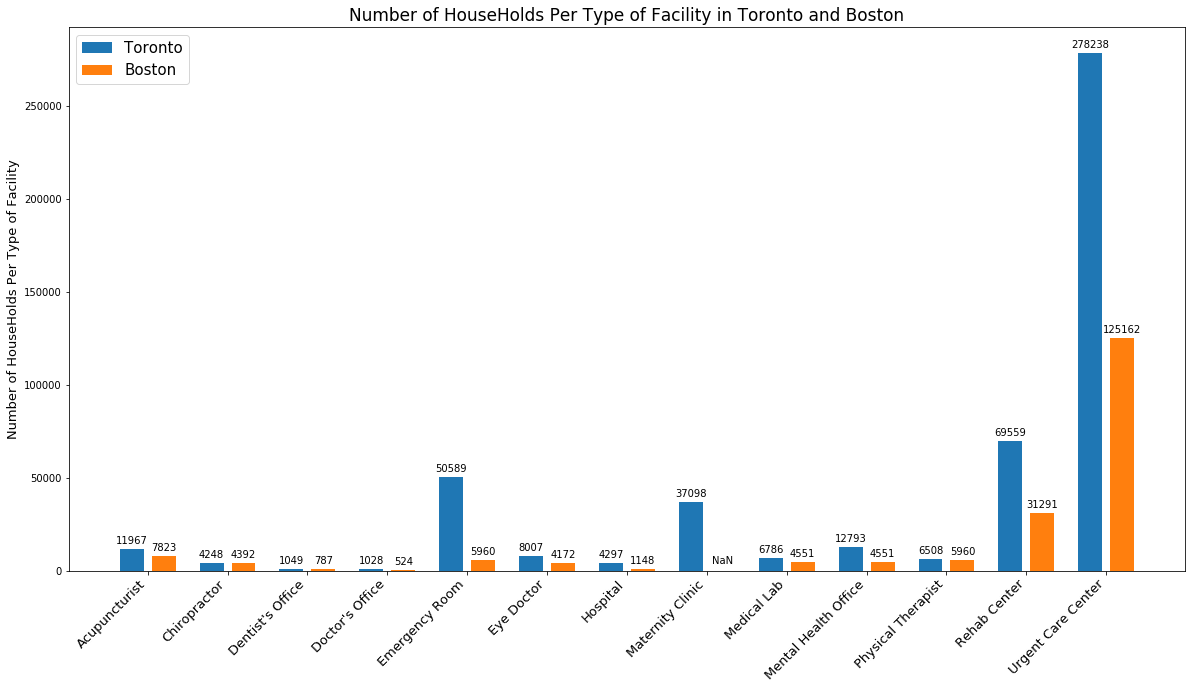

In [37]:
# plot the number of households per type of facility in toronto and boston 
toronto_hh_facility = accessibility_df.iloc[0,:]
boston_hh_facility = accessibility_df.iloc[2, :]
comparison_labels = accessibility_df.columns
hh_y_label = 'Number of HouseHolds Per Type of Facility'
hh_title = 'Number of HouseHolds Per Type of Facility in Toronto and Boston'

city_comparision(toronto_hh_facility, boston_hh_facility, comparison_labels, hh_y_label, hh_title)

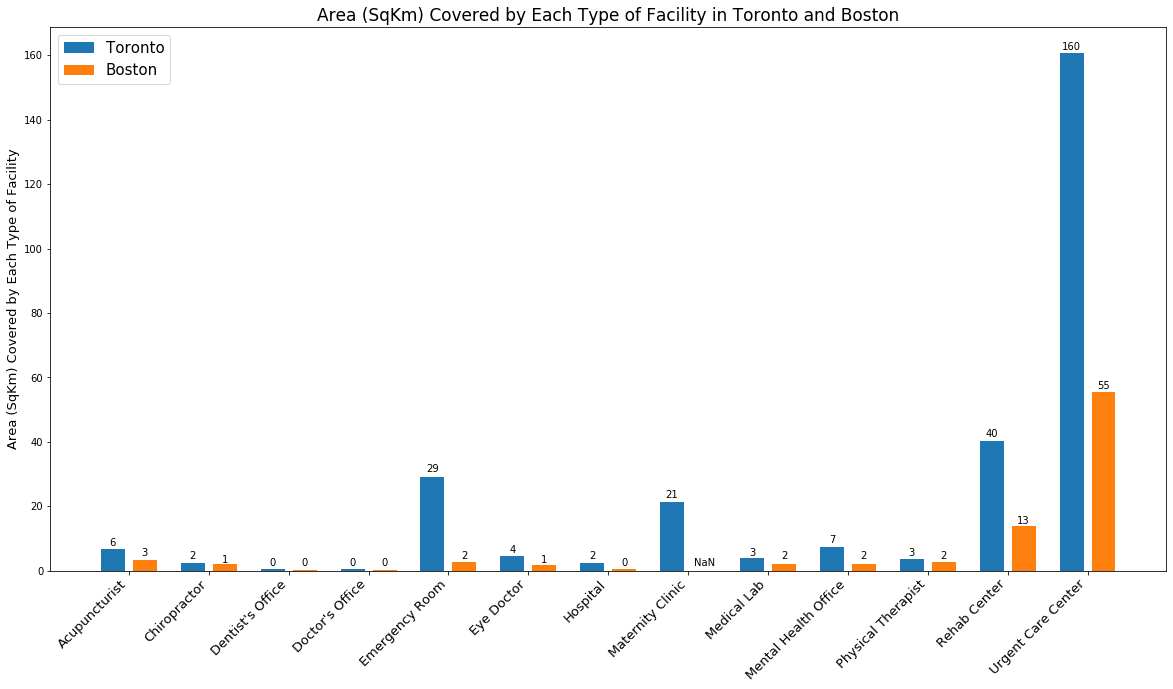

In [38]:
# plot the arae covered by each type of facility in toronto and boston
toronto_area_facility = accessibility_df.iloc[1,:]
boston_area_facility = accessibility_df.iloc[3, :]
comparison_labels = accessibility_df.columns
area_y_label ='Area (SqKm) Covered by Each Type of Facility'
area_title = 'Area (SqKm) Covered by Each Type of Facility in Toronto and Boston'

city_comparision(toronto_area_facility, boston_area_facility, comparison_labels, area_y_label, area_title)

<h3>Let's now examine the cost spent on healthcare in each city</h3>

In [39]:
# create a dataframe that stores cost information, columns cover heatlhcare expenditure and all other expenditure
cost_df = pd.DataFrame(index = ['Toronto', 'Boston'], columns= ['Average Income', 'Healthcare Cost', 'Other Cost'])
cost_df.loc['Toronto', 'Average Income'] = toronto_df['Income of Households'].mean()
cost_df.loc['Boston', 'Average Income'] = boston_df['Income of Households'].mean()
# manually enter teh healthcare expenditure information found onlinefor entire Ontario and Massachusetts
cost_df.loc['Toronto', 'Healthcare Cost'] = 12935
cost_df.loc['Boston', 'Healthcare Cost'] = 21085
cost_df.loc[:, 'Other Cost'] = cost_df.loc[:, 'Average Income'] - cost_df.loc[:, 'Healthcare Cost']
cost_df.drop(columns = ['Average Income'], inplace = True)

cost_df

,Healthcare Cost,Other Cost
Toronto,12935,53601.5
Boston,21085,52015.6


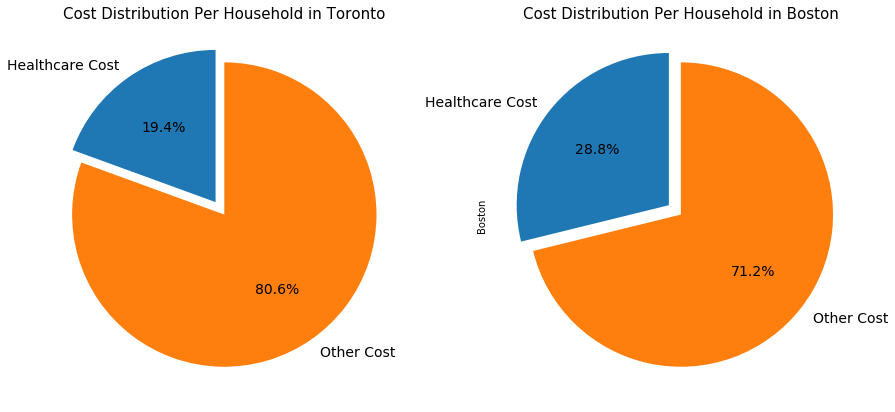

In [40]:
# use pie plot to illustrate the average healthcare cost for each household in toronto and boston
fig = plt.figure(figsize=(15, 10))
ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)
explode = (0.1, 0)

cost_df.loc['Toronto'].plot(kind = 'pie', explode = explode, autopct = '%1.1f%%', 
                            textprops={'fontsize': 14}, startangle = 90, ax = ax0)
cost_df.loc['Boston'].plot(kind = 'pie', explode = explode, autopct = '%1.1f%%', 
                           textprops={'fontsize': 14}, startangle = 90, ax = ax1)

ax0.set_title('Cost Distribution Per Household in Toronto', fontsize = 15)
ax0.set_ylabel("")
ax1.set_title('Cost Distribution Per Household in Boston', fontsize = 15)
ax0.set_xlabel("")

plt.show()

<h1>Now the next Part of the project</h1>
In this part of the project, I assume an imaginary friend who wants to open a healthcare facility in Toronto. He has not decided exactly what type of healthcare service he will be providing and has approached me for help. To clearify the problem, I will analyze the current distribution of all healthcare facilities in Toronto, cluster them into different group to make a suitable recommendation.

In [41]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [42]:
toronto_facility_df.head()

,Acupuncturist,Chiropractor,Dentist's Office,Doctor's Office,Emergency Room,Eye Doctor,Hospital,Maternity Clinic,Medical Lab,Mental Health Office,Physical Therapist,Rehab Center,Urgent Care Center
Etobicoke North,1,4,29,41,0,2,6,0,4,0,1,1,1
Etobicoke Centre,6,10,50,50,0,10,1,0,3,1,8,0,0
Etobicoke-Lakeshore,5,18,50,50,0,12,5,1,3,2,9,0,0
Parkdale-High Park,0,7,50,45,0,3,4,1,2,7,5,0,0
York South-Weston,1,1,18,26,0,1,10,0,1,1,1,0,0


In [43]:
# normalize the dataframe before performing k-means clustering
scaler = StandardScaler()
normalized_toronto_facility_data = scaler.fit_transform(toronto_facility_df)
normalized_toronto_facility_df = pd.DataFrame(normalized_toronto_facility_data, index = toronto_facility_df.index, columns= toronto_facility_df.columns)
normalized_toronto_facility_df.head()

,Acupuncturist,Chiropractor,Dentist's Office,Doctor's Office,Emergency Room,Eye Doctor,Hospital,Maternity Clinic,Medical Lab,Mental Health Office,Physical Therapist,Rehab Center,Urgent Care Center
Etobicoke North,-0.715750,-0.691992,-1.246121,-0.212945,-0.60645,-0.685549,-0.319837,-0.884652,-0.408848,-0.768798,-1.180958,0.524891,2.291288
Etobicoke Centre,0.599967,-0.051259,0.700943,0.613134,-0.60645,0.855011,-0.686622,-0.884652,-0.568554,-0.547879,0.234574,-0.933139,-0.436436
Etobicoke-Lakeshore,0.336823,0.803052,0.700943,0.613134,-0.60645,1.240150,-0.393194,-0.147442,-0.568554,-0.326960,0.436793,-0.933139,-0.436436
Parkdale-High Park,-0.978893,-0.371625,0.700943,0.154201,-0.60645,-0.492979,-0.466551,-0.147442,-0.728260,0.777635,-0.372083,-0.933139,-0.436436
York South-Weston,-0.715750,-1.012358,-2.266011,-1.589743,-0.60645,-0.878119,-0.026409,-0.884652,-0.887966,-0.547879,-1.180958,-0.933139,-0.436436


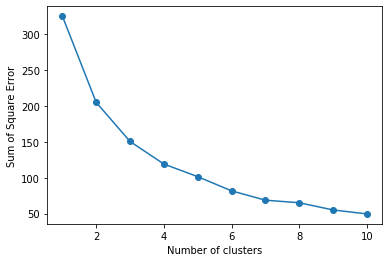

In [44]:
# loop through different values of clusters to determine the best value for cluster number
SSE = []

for i in range(1, 11):
    kmeans = KMeans(
        n_clusters=i, init='random',
        n_init=12, max_iter=500, random_state=0)
    kmeans.fit(normalized_toronto_facility_df)
    SSE.append(kmeans.inertia_)

# plot
plt.plot(range(1, 11), SSE, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Square Error')
plt.show()

In this case, it can be seen that there there is no noticeable 'elbow' to determine the best cluster value. This suggests that there might exisit no intrict similarities or differences among the data. However, the value 6 seems to give slighter shaper change in SSE, and is therefore selected to the following section. 

In [45]:
kclusters = 6
# perform k means cluster
kmeans = KMeans(init = "random", n_clusters=kclusters, random_state=0, n_init = 12).fit(normalized_toronto_facility_df)
# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([5, 2, 2, 3, 4, 3, 4, 5, 3, 1, 0, 2, 2, 5, 1, 2, 2, 2, 3, 4, 3, 3,
       5, 3, 3], dtype=int32)

In [46]:
# insert the cluster label back into the dataframe
toronto_percentage_final_df = toronto_facility_percentage_df
toronto_percentage_final_df.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_percentage_final_df.head()

,Cluster Labels,Acupuncturist,Chiropractor,Dentist's Office,Doctor's Office,Emergency Room,Eye Doctor,Hospital,Maternity Clinic,Medical Lab,Mental Health Office,Physical Therapist,Rehab Center,Urgent Care Center
Etobicoke North,5,1.11,4.44,32.22,45.56,0.0,2.22,6.67,0.00,4.44,0.00,1.11,1.11,1.11
Etobicoke Centre,2,4.32,7.19,35.97,35.97,0.0,7.19,0.72,0.00,2.16,0.72,5.76,0.00,0.00
Etobicoke-Lakeshore,2,3.23,11.61,32.26,32.26,0.0,7.74,3.23,0.65,1.94,1.29,5.81,0.00,0.00
Parkdale-High Park,3,0.00,5.65,40.32,36.29,0.0,2.42,3.23,0.81,1.61,5.65,4.03,0.00,0.00
York South-Weston,4,1.67,1.67,30.00,43.33,0.0,1.67,16.67,0.00,1.67,1.67,1.67,0.00,0.00


To help with visualization, I have used the Toronto map created in earlier section and color coded each marker to present the result fo clustering.

In [47]:
# color code the marker and assign each marker to the corresponding cluster group
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

map_toronto_cluster = folium.Map(location = [toronto_latitude, toronto_longitude], zoom_start = 11)

for lat, long, ward, cluster in zip(toronto_df['Lat'], toronto_df['Long'], toronto_df.index, toronto_percentage_final_df['Cluster Labels']):
    label_dic = {}
    for facility in toronto_facility_percentage_df.columns:
        if toronto_facility_percentage_df.loc[ward, facility] != 0:
            label_dic[facility] = toronto_facility_percentage_df.loc[ward, facility]
    label_df = pd.DataFrame.from_dict(label_dic, orient='index')
    label_df.columns = ['Percentage']
    label_df.sort_values(by = ['Percentage'], ascending = False, inplace = True)
    label_html = label_df.to_html(classes='table table-striped table-hover table-condensed table-responsive')
    label = folium.Popup('<h4>'+ ward + ' - Cluster ' + str(cluster) + '</h4>'+ label_html, max_width = 250)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto_cluster)

map_toronto_cluster

In [48]:
# define a function for sorting the most common facility type in each toronto ward
def return_most_common_facilities(row, num_top_facilities):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_facilities]

# then apply the function to find the top 10 venue categories
num_top_facilities = 9

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Wards']
for ind in np.arange(num_top_facilities):
    try:
        columns.append('{}{} Most Common facility'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common facility'.format(ind+1))

# create a new dataframe
wards_facilities_sorted = pd.DataFrame(columns=columns)
wards_facilities_sorted['Wards'] = toronto_df.index

for ind in np.arange(toronto_percentage_final_df.shape[0]):
    wards_facilities_sorted.iloc[ind, 1:] = return_most_common_facilities(toronto_percentage_final_df.iloc[ind, :], num_top_facilities)

wards_facilities_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
wards_facilities_sorted.head()

,Cluster Labels,Wards,1st Most Common facility,2nd Most Common facility,3rd Most Common facility,4th Most Common facility,5th Most Common facility,6th Most Common facility,7th Most Common facility,8th Most Common facility,9th Most Common facility
0,5,Etobicoke North,Doctor's Office,Dentist's Office,Hospital,Medical Lab,Chiropractor,Eye Doctor,Urgent Care Center,Rehab Center,Physical Therapist
1,2,Etobicoke Centre,Doctor's Office,Dentist's Office,Eye Doctor,Chiropractor,Physical Therapist,Acupuncturist,Medical Lab,Mental Health Office,Hospital
2,2,Etobicoke-Lakeshore,Doctor's Office,Dentist's Office,Chiropractor,Eye Doctor,Physical Therapist,Hospital,Acupuncturist,Medical Lab,Mental Health Office
3,3,Parkdale-High Park,Dentist's Office,Doctor's Office,Mental Health Office,Chiropractor,Physical Therapist,Hospital,Eye Doctor,Medical Lab,Maternity Clinic
4,4,York South-Weston,Doctor's Office,Dentist's Office,Hospital,Physical Therapist,Mental Health Office,Medical Lab,Eye Doctor,Chiropractor,Acupuncturist


<h3>Each cluster group is printed to help determine the similarities within cluster, the difference among all clusters and also the more competitive facility type</h3>

Cluster 1

In [49]:
wards_facilities_sorted.loc[wards_facilities_sorted['Cluster Labels'] == 0, :].set_index(['Wards'])

,Cluster Labels,1st Most Common facility,2nd Most Common facility,3rd Most Common facility,4th Most Common facility,5th Most Common facility,6th Most Common facility,7th Most Common facility,8th Most Common facility,9th Most Common facility
Wards,,,,,,,,,,
University-Rosedale,0,Hospital,Doctor's Office,Dentist's Office,Chiropractor,Medical Lab,Physical Therapist,Mental Health Office,Eye Doctor,Acupuncturist


Cluster 2

In [50]:
wards_facilities_sorted.loc[wards_facilities_sorted['Cluster Labels'] == 1, :].set_index(['Wards'])

,Cluster Labels,1st Most Common facility,2nd Most Common facility,3rd Most Common facility,4th Most Common facility,5th Most Common facility,6th Most Common facility,7th Most Common facility,8th Most Common facility,9th Most Common facility
Wards,,,,,,,,,,
Spadina-Fort York,1,Doctor's Office,Dentist's Office,Hospital,Chiropractor,Medical Lab,Physical Therapist,Acupuncturist,Mental Health Office,Eye Doctor
Don Valley West,1,Doctor's Office,Dentist's Office,Hospital,Eye Doctor,Chiropractor,Physical Therapist,Medical Lab,Mental Health Office,Acupuncturist


Cluster 3

In [51]:
wards_facilities_sorted.loc[wards_facilities_sorted['Cluster Labels'] == 2, :].set_index(['Wards'])

,Cluster Labels,1st Most Common facility,2nd Most Common facility,3rd Most Common facility,4th Most Common facility,5th Most Common facility,6th Most Common facility,7th Most Common facility,8th Most Common facility,9th Most Common facility
Wards,,,,,,,,,,
Etobicoke Centre,2,Doctor's Office,Dentist's Office,Eye Doctor,Chiropractor,Physical Therapist,Acupuncturist,Medical Lab,Mental Health Office,Hospital
Etobicoke-Lakeshore,2,Doctor's Office,Dentist's Office,Chiropractor,Eye Doctor,Physical Therapist,Hospital,Acupuncturist,Medical Lab,Mental Health Office
Toronto-St. Paul's,2,Doctor's Office,Dentist's Office,Chiropractor,Physical Therapist,Mental Health Office,Acupuncturist,Medical Lab,Eye Doctor,Maternity Clinic
Toronto Centre,2,Doctor's Office,Dentist's Office,Hospital,Chiropractor,Medical Lab,Physical Therapist,Eye Doctor,Acupuncturist,Mental Health Office
Don Valley East,2,Doctor's Office,Dentist's Office,Eye Doctor,Physical Therapist,Medical Lab,Chiropractor,Hospital,Acupuncturist,Rehab Center
Don Valley North,2,Doctor's Office,Dentist's Office,Hospital,Medical Lab,Physical Therapist,Chiropractor,Eye Doctor,Rehab Center,Acupuncturist
Willowdale,2,Doctor's Office,Dentist's Office,Chiropractor,Medical Lab,Eye Doctor,Acupuncturist,Physical Therapist,Hospital,Mental Health Office


Cluster 4

In [52]:
wards_facilities_sorted.loc[wards_facilities_sorted['Cluster Labels'] == 3, :].set_index(['Wards'])

,Cluster Labels,1st Most Common facility,2nd Most Common facility,3rd Most Common facility,4th Most Common facility,5th Most Common facility,6th Most Common facility,7th Most Common facility,8th Most Common facility,9th Most Common facility
Wards,,,,,,,,,,
Parkdale-High Park,3,Dentist's Office,Doctor's Office,Mental Health Office,Chiropractor,Physical Therapist,Hospital,Eye Doctor,Medical Lab,Maternity Clinic
York Centre,3,Doctor's Office,Dentist's Office,Medical Lab,Chiropractor,Physical Therapist,Mental Health Office,Eye Doctor,Acupuncturist,Rehab Center
Davenport,3,Dentist's Office,Doctor's Office,Mental Health Office,Eye Doctor,Chiropractor,Physical Therapist,Medical Lab,Maternity Clinic,Hospital
Beaches-East York,3,Doctor's Office,Dentist's Office,Hospital,Chiropractor,Physical Therapist,Medical Lab,Emergency Room,Mental Health Office,Eye Doctor
Scarborough Centre,3,Dentist's Office,Doctor's Office,Hospital,Physical Therapist,Medical Lab,Chiropractor,Eye Doctor,Emergency Room,Urgent Care Center
Scarborough-Agincourt,3,Doctor's Office,Dentist's Office,Medical Lab,Physical Therapist,Acupuncturist,Hospital,Chiropractor,Maternity Clinic,Eye Doctor
Scarborough-Guildwood,3,Dentist's Office,Doctor's Office,Hospital,Chiropractor,Physical Therapist,Medical Lab,Acupuncturist,Mental Health Office,Maternity Clinic
Scarborough-Rouge Park,3,Doctor's Office,Dentist's Office,Hospital,Chiropractor,Medical Lab,Physical Therapist,Maternity Clinic,Emergency Room,Urgent Care Center


Cluster 5

In [53]:
wards_facilities_sorted.loc[wards_facilities_sorted['Cluster Labels'] == 4, :].set_index(['Wards'])

,Cluster Labels,1st Most Common facility,2nd Most Common facility,3rd Most Common facility,4th Most Common facility,5th Most Common facility,6th Most Common facility,7th Most Common facility,8th Most Common facility,9th Most Common facility
Wards,,,,,,,,,,
York South-Weston,4,Doctor's Office,Dentist's Office,Hospital,Physical Therapist,Mental Health Office,Medical Lab,Eye Doctor,Chiropractor,Acupuncturist
Humber River-Black Creek,4,Doctor's Office,Dentist's Office,Hospital,Eye Doctor,Chiropractor,Medical Lab,Rehab Center,Mental Health Office,Acupuncturist
Scarborough Southwest,4,Dentist's Office,Doctor's Office,Medical Lab,Hospital,Chiropractor,Rehab Center,Physical Therapist,Urgent Care Center,Mental Health Office


Cluster 6

In [54]:
wards_facilities_sorted.loc[wards_facilities_sorted['Cluster Labels'] == 5, :].set_index(['Wards'])

,Cluster Labels,1st Most Common facility,2nd Most Common facility,3rd Most Common facility,4th Most Common facility,5th Most Common facility,6th Most Common facility,7th Most Common facility,8th Most Common facility,9th Most Common facility
Wards,,,,,,,,,,
Etobicoke North,5,Doctor's Office,Dentist's Office,Hospital,Medical Lab,Chiropractor,Eye Doctor,Urgent Care Center,Rehab Center,Physical Therapist
Eglinton-Lawrence,5,Doctor's Office,Dentist's Office,Chiropractor,Physical Therapist,Eye Doctor,Hospital,Acupuncturist,Urgent Care Center,Rehab Center
Toronto-Danforth,5,Doctor's Office,Dentist's Office,Chiropractor,Mental Health Office,Medical Lab,Eye Doctor,Physical Therapist,Hospital,Acupuncturist
Scarborough North,5,Doctor's Office,Dentist's Office,Physical Therapist,Medical Lab,Acupuncturist,Chiropractor,Rehab Center,Eye Doctor,Urgent Care Center


<h2>Conclusion<\h2>

In this part, I used K-means clustering to divide Toronto wards into 6 different clusters based on healthcare facility distribution, for making business recommendations. However, due to the lack of a clear elbow point in the 'sum of error' vs 'number of clusters' graph, it can be seen that the distribution of different types of healthcare facilities is not the best feature for using k-means clustering. This might be caused by the lack of similarities within each cluster and differences among cluster. Further study should include other factors such as age distribution and income distribution within each ward, which potentially impact the business aspects of a healthcare facility. 